# Imports

In [1]:
import os
import yaml
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from PIL import Image

# For interactive progress bars (very helpful for large datasets like 6.5k images)
from tqdm.notebook import tqdm 

# Setting visualization style
sns.set(style="whitegrid")
%matplotlib inline

# Data Extraction

In [2]:
def load_yolo_metadata_diagnostic(base_path, split='train'):
    image_dir = Path(base_path) / split / 'images'
    label_dir = Path(base_path) / split / 'labels'
    
    print(f"--- Checking Directory: {image_dir} ---")
    
    # Check if the directory even exists
    if not image_dir.exists():
        print(f"❌ ERROR: Image directory NOT found at {image_dir}")
        return pd.DataFrame()

    image_files = glob.glob(str(image_dir / "*"))
    print(f"🔍 Found {len(image_files)} image files.")

    data_rows = []
    for img_path in tqdm(image_files, desc=f"Processing {split}"):
        # Diagnostic: Only print the first 2 files to save space
        if len(data_rows) < 2:
            print(f"Reading: {os.path.basename(img_path)}")
            
        label_path = label_dir / (os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        data_rows.append({
                            'split': split, 'img_path': img_path, 
                            'class_id': int(parts[0]),
                            'x_center': float(parts[1]), 'y_center': float(parts[2]), 
                            'width': float(parts[3]), 'height': float(parts[4])
                        })
        else:
            data_rows.append({'split': split, 'img_path': img_path, 'class_id': -1})

    # CRITICAL: If data_rows is empty, the DataFrame will be empty
    df = pd.DataFrame(data_rows)
    print(f"✅ Finished! Created DataFrame with {len(df)} rows.")
    return df


In [3]:
# 1. Define the base path for your YOLOv8 dataset
# Note: Using v3i as the primary, but you can swap to 'v5-good-aug' if preferred
DATASET_ROOT = "/kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8"

# 2. Load all splits using your diagnostic function
print("--- LOADING TRAIN DATA ---")
df_train = load_yolo_metadata_diagnostic(DATASET_ROOT, 'train')

print("\n--- LOADING VALIDATION DATA ---")
df_valid = load_yolo_metadata_diagnostic(DATASET_ROOT, 'valid')

print("\n--- LOADING TEST DATA ---")
df_test = load_yolo_metadata_diagnostic(DATASET_ROOT, 'test')

# 3. Combine into one Master DataFrame for full dataset EDA
full_df = pd.concat([df_train, df_valid, df_test], ignore_index=True)

# 4. Final Verification
print("\n" + "="*30)
print(f"Total images found: {full_df['img_path'].nunique()}")
print(f"Total annotations found: {len(full_df[full_df['class_id'] != -1])}")
print(f"Empty/Background images: {len(full_df[full_df['class_id'] == -1])}")
print("="*30)

# Show the first few rows of the combined metadata
display(full_df.sample(5))

--- LOADING TRAIN DATA ---
--- Checking Directory: /kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8/train/images ---
🔍 Found 4867 image files.


Processing train:   0%|          | 0/4867 [00:00<?, ?it/s]

Reading: vaca176_jpg.rf.a69f1f41f6c7751bd1dc3813d366e85b.jpg
Reading: B1_1918_342_870_json_img_png.rf.637c5f002c89a3cf4feb809caf05634b.jpg
✅ Finished! Created DataFrame with 16457 rows.

--- LOADING VALIDATION DATA ---
--- Checking Directory: /kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8/valid/images ---
🔍 Found 1195 image files.


Processing valid:   0%|          | 0/1195 [00:00<?, ?it/s]

Reading: horse21-9_png_jpg.rf.1343e68be1829b835fc5ed01d1cda1c6.jpg
Reading: koyun-190-_jpg.rf.17b4f63d478e61b9ad2db03123f872f3.jpg
✅ Finished! Created DataFrame with 4012 rows.

--- LOADING TEST DATA ---
--- Checking Directory: /kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8/test/images ---
🔍 Found 508 image files.


Processing test:   0%|          | 0/508 [00:00<?, ?it/s]

Reading: pig1_197_jpg.rf.b497b894fee259138277d2b8b36ac934.jpg
✅ Finished! Created DataFrame with 1873 rows.

Total images found: 6570
Total annotations found: 22342
Empty/Background images: 0


,split,img_path,class_id,x_center,y_center,width,height
3699,train,/kaggle/input/cattle-dataset-pig-sheep-cow-hor...,3,0.487305,0.333333,0.472656,0.368490
5975,train,/kaggle/input/cattle-dataset-pig-sheep-cow-hor...,2,0.499479,0.238889,0.486979,0.252778
11164,train,/kaggle/input/cattle-dataset-pig-sheep-cow-hor...,2,0.344271,0.442593,0.339323,0.449074
20905,test,/kaggle/input/cattle-dataset-pig-sheep-cow-hor...,0,0.000000,0.557617,0.013672,0.594727
17500,valid,/kaggle/input/cattle-dataset-pig-sheep-cow-hor...,2,0.485156,0.297222,0.491146,0.292130


# Class Distribution Analysis

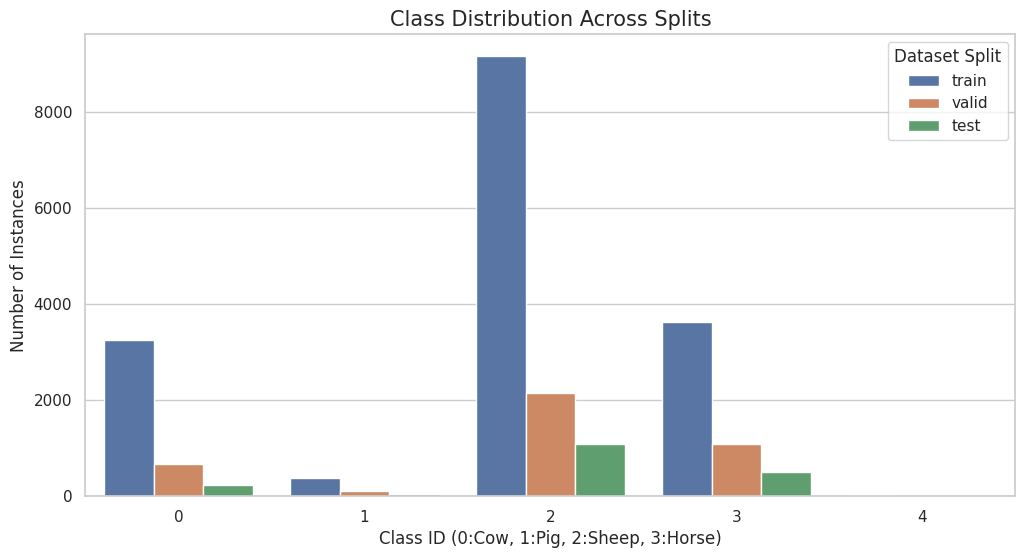

Instance Counts per Class:
class_id
0     4146
1      545
2    12388
3     5239
4       24
Name: count, dtype: int64


In [4]:
# Create a count plot for classes
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=full_df[full_df['class_id'] != -1], x='class_id', hue='split')

# Add class names from your yaml (if available) for clarity
# If you don't have the 'classes' list yet: classes = ['Cow', 'Pig', 'Sheep', 'Horse']
plt.title("Class Distribution Across Splits", fontsize=15)
plt.xlabel("Class ID (0:Cow, 1:Pig, 2:Sheep, 3:Horse)", fontsize=12)
plt.ylabel("Number of Instances", fontsize=12)
plt.legend(title="Dataset Split")
plt.show()

# Print exact counts
print("Instance Counts per Class:")
print(full_df['class_id'].value_counts().sort_index())

# Bounding Box Heatmap

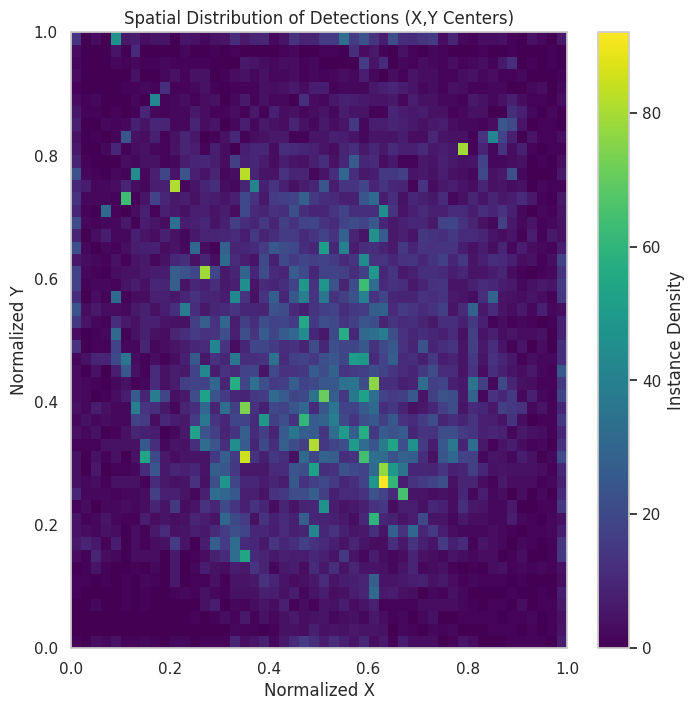

In [5]:
plt.figure(figsize=(8, 8))
plt.hist2d(full_df['x_center'], full_df['y_center'], bins=50, cmap='viridis')
plt.colorbar(label='Instance Density')
plt.title("Spatial Distribution of Detections (X,Y Centers)")
plt.xlabel("Normalized X")
plt.ylabel("Normalized Y")
plt.show()

# Visual Verification 

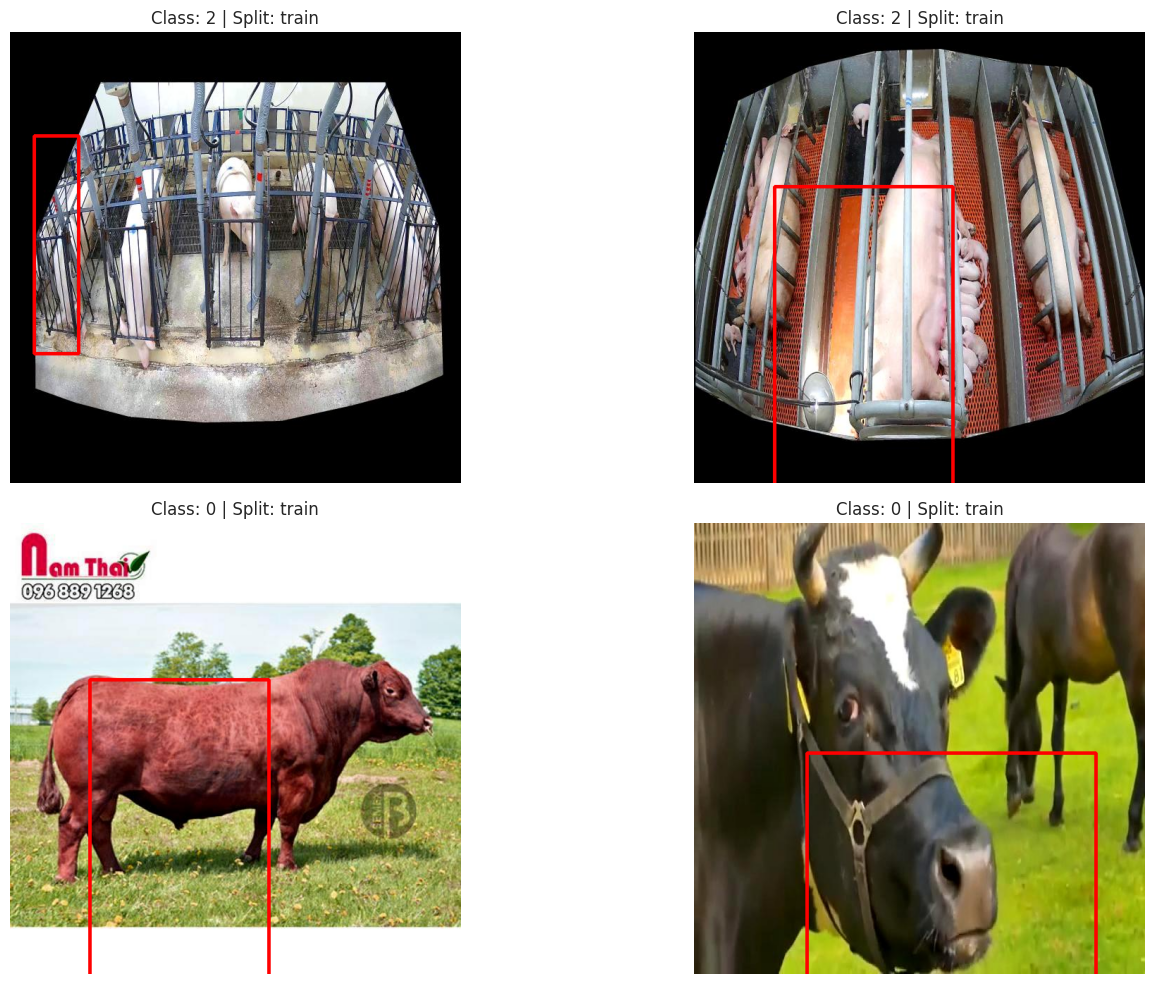

In [6]:
def plot_random_samples(df, num_samples=4):
    sample_imgs = df[df['class_id'] != -1].sample(num_samples)
    plt.figure(figsize=(16, 10))
    
    for i, (idx, row) in enumerate(sample_imgs.iterrows()):
        img = cv2.imread(row['img_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Convert YOLO normalized to Pixel coordinates
        x1 = int((row['x_center'] - row['width']/2) * w)
        y1 = int((row['y_center'] - row['height']/2) * h)
        x2 = int((row['x_center'] + row['width']/2) * w)
        y2 = int((row['y_center'] + row['height']/2) * h)
        
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f"Class: {row['class_id']} | Split: {row['split']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_samples(full_df)

# Dataset Statistics

In [7]:
def get_dataset_stats(df):
    # 1. Image-level stats
    img_stats = df.groupby('split')['img_path'].nunique()
    
    # 2. Instance-level stats (excluding background -1)
    obj_df = df[df['class_id'] != -1]
    instance_stats = obj_df.groupby('split').size()
    
    # 3. Class-level breakdown
    class_breakdown = obj_df.groupby(['split', 'class_id']).size().unstack(fill_value=0)
    
    # 4. Average Objects Per Image
    avg_objs = (instance_stats / img_stats).round(2)
    
    # Combine into a final summary table
    summary = pd.DataFrame({
        'Total Images': img_stats,
        'Total Instances': instance_stats,
        'Avg Objects/Image': avg_objs
    })
    
    return summary, class_breakdown

# Execute
stats_summary, class_details = get_dataset_stats(full_df)

print("📊 DATASET SPLIT OVERVIEW")
display(stats_summary)

print("\n🐾 CLASS DISTRIBUTION PER SPLIT")
# Mapping IDs to names for clarity
class_names = {0: 'Cow', 1: 'Pig', 2: 'Sheep', 3: 'Horse'}
class_details.columns = [class_names.get(c, f"Class_{c}") for c in class_details.columns]
display(class_details)

📊 DATASET SPLIT OVERVIEW


,Total Images,Total Instances,Avg Objects/Image
split,,,
test,508,1873,3.69
train,4867,16457,3.38
valid,1195,4012,3.36



🐾 CLASS DISTRIBUTION PER SPLIT


,Cow,Pig,Sheep,Horse,Class_4
split,,,,,
test,224,47,1082,515,5
train,3259,388,9165,3627,18
valid,663,110,2141,1097,1
